## Classification of Seismic Events Using Unsupervised Machine Learning
### Deep Learning Section
#### By Jeff Church (churchjm@umich.edu), Dongdong Yao (dongdony@umich.edu), and Yihe Huang (yiheh@umich.edu)

This notebook contains an unsupervised clustering analysis of waveforms retrieved from the [TA:O53A](http://ds.iris.edu/mda/TA/O53A/?starttime=2012-12-13T00:00:00&endtime=2018-09-27T23:59:59) seismograph station located in New Philadelphia, OH.  The analysis is performed using the Deep Embedded Clustering (DEC) architecture by [Xie, Girshick, and Farhadi](https://arxiv.org/abs/1511.06335).

First, the notebook's DEC code is validated by reproducing the DEC authors' experiment on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).  Next, the architecture is tuned to provide good clustering results on a labeled dataset containing 1,251 induced earthquakes and 5,152 mining blasts recorded by TA:O53A.  Finally, DEC is tested on a completely unlabeled dataset retrieved from TA:O53A using the [PhaseNet](https://arxiv.org/abs/1803.03211) tool (N=7,398).  All waveform analyses are performed on spectrograms computed from the vertical seismogram channel only.

Because the dataset of interest is unlabeled, the notebook concludes by calculating summary statistics to evaluate the clustering results.  Links to an interactive visualization tool are also provided for manual cluster exploration.

**All data files used by this notebook can be downloaded [here](https://drive.google.com/drive/folders/1-Eex84NC7S8D0qj-rliZ34Xw5-PKQuaS?usp=sharing).**

## Functions and Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from time import time
import os
import numpy as np
import keras.backend as K
#from tensorflow.keras.engine.topology import Layer, InputSpec
#from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Layer, InputSpec
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.random import set_seed
import random
from keras.datasets import mnist
import json
import pandas as pd

The following cell contains an implementation of the DEC architecture.  The code was copied from the [DEC github repository](https://github.com/XifengGuo/DEC-keras) with some modifications.

In [ ]:
class ClusteringLayer(Layer):
  """
  Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
  sample belonging to each cluster. The probability is calculated with student's t-distribution.

  # Example
  ```
      model.add(ClusteringLayer(n_clusters=10))
  ```
  # Arguments
      n_clusters: number of clusters.
      weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
      alpha: parameter in Student's t-distribution. Default to 1.0.
  # Input shape
      2D tensor with shape: `(n_samples, n_features)`.
  # Output shape
      2D tensor with shape: `(n_samples, n_clusters)`.
  """

  def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
        kwargs['input_shape'] = (kwargs.pop('input_dim'),)
    super(ClusteringLayer, self).__init__(**kwargs)
    self.n_clusters = n_clusters
    self.alpha = alpha
    self.initial_weights = weights
    self.input_spec = InputSpec(ndim=2)

  def build(self, input_shape):
    assert len(input_shape) == 2
    input_dim = input_shape[1]
    self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
    self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
    if self.initial_weights is not None:
        self.set_weights(self.initial_weights)
        del self.initial_weights
    self.built = True

  def call(self, inputs, **kwargs):
    """ student t-distribution, as same as used in t-SNE algorithm.
              q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
    Arguments:
        inputs: the variable containing data, shape=(n_samples, n_features)
    Return:
        q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
    """
    q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q **= (self.alpha + 1.0) / 2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
    return q

  def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) == 2
    return input_shape[0], self.n_clusters

  def get_config(self):
    config = {'n_clusters': self.n_clusters}
    base_config = super(ClusteringLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

def acc(y_true, y_pred):
  """
  Calculate clustering accuracy. Require scikit-learn installed

  # Arguments
      y: true labels, numpy.array with shape `(n_samples,)`
      y_pred: predicted labels, numpy.array with shape `(n_samples,)`

  # Return
      accuracy, in [0,1]
  """
  y_true = y_true.astype(np.int64)
  assert y_pred.size == y_true.size
  D = max(y_pred.max(), y_true.max()) + 1
  w = np.zeros((D, D), dtype=np.int64)
  for i in range(y_pred.size):
      w[y_pred[i], y_true[i]] += 1
  from scipy.optimize import linear_sum_assignment as linear_assignment
  ind = linear_assignment(w.max() - w)
  #return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
  return w[ind[0], ind[1]].sum() * 1.0 / y_pred.size

def target_distribution(q):
  weight = q ** 2 / q.sum(0)
  return (weight.T / weight.sum(1)).T

def get_autoencoder(dims, act='relu', init='glorot_uniform'):
  """
  Fully connected auto-encoder model, symmetric.
  Arguments:
      dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
          The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
      act: activation, not applied to Input, Hidden and Output layers
  return:
      (ae_model, encoder_model), Model of autoencoder and model of encoder
  """
  n_stacks = len(dims) - 1
  # input
  x = Input(shape=(dims[0],), name='input')
  h = x

  # internal layers in encoder
  for i in range(n_stacks-1):
    h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

  # hidden layer
  h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

  y = h
  # internal layers in decoder
  for i in range(n_stacks-1, 0, -1):
    y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

  # output
  y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

  return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')

def pretrain(autoencoder, x, y=None, optimizer='adam', epochs=300, batch_size=256, acc_list=None):
  print('...Pretraining...')
  
  autoencoder.compile(optimizer=optimizer, loss='mse')

  cb = []
  if y is not None:
    class PrintACC(callbacks.Callback):
      def __init__(self, x, y):
        self.x = x
        self.y = y
        super(PrintACC, self).__init__()

      def on_epoch_end(self, epoch, logs=None):
        #print(epoch, int(epochs/10), epoch % int(epochs/10))
        #if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
        if (epoch+1) != 1 and (epoch+1) % int(epochs/10) != 0:
          return
        feature_model = Model(self.model.input, self.model.get_layer('encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
        features = feature_model.predict(self.x)
        km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4, random_state=RANDOM_SEED)
        y_pred = km.fit_predict(features)

        epoch_acc = round(acc(self.y, y_pred), 4)
        acc_list.append((epoch+1,epoch_acc))
        print(f'Clustering accuracy: {epoch_acc}')

    cb.append(PrintACC(x, y))

  # begin pretraining
  autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)

def fit(x, y=None, model=None, encoder=None, maxiter=2e4, batch_size=256, tol=1e-3, update_interval=140, acc_list=None):
  print('Update interval', update_interval)

  # Step 1: initialize cluster centers using k-means
  print('Initializing cluster centers with k-means.')
  kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=RANDOM_SEED)
  y_pred = kmeans.fit_predict(encoder.predict(x))
  y_pred_last = np.copy(y_pred)
  model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

  loss = 0
  index = 0
  index_array = np.arange(x.shape[0])
  for ite in range(int(maxiter)):
    if ite % update_interval == 0:
      q = model.predict(x, verbose=0)
      p = target_distribution(q)  # update the auxiliary target distribution p

      # evaluate the clustering performance
      y_pred = q.argmax(1)
      if y is not None:
        clust_acc = np.round(acc(y, y_pred), 5)
        loss = np.round(loss, 5)
        acc_list.append((ite,clust_acc))
        print(f'Iteration: {ite}.  Clustering Accuracy: {clust_acc}.  Loss: {loss}.')

      # check stop criterion
      delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
      y_pred_last = np.copy(y_pred)
      if ite > 0 and delta_label < tol:
        print('delta_label ', delta_label, '< tol ', tol)
        print('Reached tolerance threshold. Stopping training.')
        break

    # train on batch
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

    ite += 1 # TODO: Why +1?

  return y_pred

Embedding and plotting functions.

In [ ]:
def get_color(label):
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
  return colors[label]

def get_colors(labels):
  colors = []
  for label in labels:
    colors.append(get_color(label))
  return colors

def get_tsne_embedding(X, encoder):
  X_latent = encoder.predict(X)
  tsne = TSNE(random_state=RANDOM_SEED).fit_transform(X_latent)  
  return tsne

Data paths and random seed settings.  When running this notebook in a local environment, point ROOT_PATH to the location of the downloaded data files.

In [ ]:
ROOT_PATH = r'/content/drive/Shared drives/Capstone/Data'

LABELED_PATH = f'{ROOT_PATH}/Labeled EQ and Blasts/'
PHASENET_PATH = f'{ROOT_PATH}/PhaseNet Picks'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED) 
set_seed(RANDOM_SEED)

N_CLUSTERS = None

Prepare MNIST, labeled, and PhaseNet datasets.

In [ ]:
# Load and process labeled dataset
eq_spectrograms = np.load(f'{LABELED_PATH}/spectrograms_eq.npy')
eq_timestamps = np.load(f'{LABELED_PATH}/timestamps_eq.npy')

blast_spectrograms = np.load(f'{LABELED_PATH}/spectrograms_blast.npy')
blast_timestamps = np.load(f'{LABELED_PATH}/timestamps_blast.npy')

spectrograms_labeled = np.vstack([eq_spectrograms, blast_spectrograms])

labels = [1]*len(eq_spectrograms)
labels.extend([0]*len(blast_spectrograms))

X_labeled, y_labeled = shuffle(spectrograms_labeled, labels, random_state=RANDOM_SEED)
X_labeled = X_labeled.reshape((X_labeled.shape[0], -1))
y_labeled = np.asarray(y_labeled)

# Load and process PhaseNet picks
phasenet_spectrograms = np.load(f'{PHASENET_PATH}/spectrograms_phasenet.npy')
phasenet_wforms_downsample = np.load(f'{PHASENET_PATH}/wforms_phasenet_downsample.npy')
phasenet_timestamps = np.load(f'{PHASENET_PATH}/timestamps_phasenet.npy')

X_pn = phasenet_spectrograms
X_pn = X_pn.reshape((X_pn.shape[0], -1))

# Load and process MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_mnist = np.concatenate((X_train, X_test))
y_mnist = np.concatenate((y_train, y_test))
X_mnist = X_mnist.reshape((X_mnist.shape[0], -1))
X_mnist = np.divide(X_mnist, 255.)

print(X_labeled.shape, y_labeled.shape)
print(X_pn.shape)
print(X_mnist.shape, y_mnist.shape)

(6403, 3072) (6403,)
(7398, 3072)
(70000, 784) (70000,)


## Reproduce MNIST experiment

Results from the DEC paper's MNIST experiment are replicated in this section.  Results will vary slightly each time the notebook is run.  Clustering accuracy following autoencoder pretraining should be approximately 82%, with a 6-8% increase in accuracy following the tuning phase.  These results are in line with the paper.

In [ ]:
N_CLUSTERS = 10

mnist_pretrain_acc = []

# Last digit is the bottleneck dimension (10)
autoencoder_mnist, encoder_mnist = get_autoencoder(dims=[X_mnist.shape[-1], 500, 500, 2000, 10])
pretrain(autoencoder_mnist, X_mnist, y=y_mnist, acc_list=mnist_pretrain_acc)

#print(mnist_pretrain_acc)

...Pretraining...
Epoch 1/300
274/274 [==============================] - 2s 4ms/step - loss: 0.0382
Clustering accuracy: 0.5214
Epoch 2/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0212
Epoch 3/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0185
Epoch 4/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0171
Epoch 5/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0161
Epoch 6/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0154
Epoch 7/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 8/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 9/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 10/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 11/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0134
Epoch 12/300
274/274 [============================

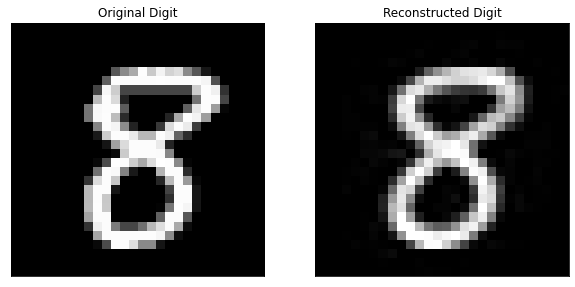

In [ ]:
digit = X_mnist[333]
reconstructed = autoencoder_mnist.predict(np.asarray([digit]))

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.imshow(digit.reshape(28,28), cmap='gray', vmin = 0, vmax = 1,interpolation='none');
plt.title('Original Digit')

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.imshow(reconstructed.squeeze().reshape(28, 28), cmap='gray', vmin = 0, vmax = 1,interpolation='none')
plt.title('Reconstructed Digit');

In [ ]:
tsne_mnist_pre = get_tsne_embedding(X_mnist, encoder_mnist)

In [ ]:
kmeans_mnist = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
y_pred_mnist = kmeans_mnist.fit_predict(encoder_mnist.predict(X_mnist))

pretrain_acc_mnist = round(acc(y_mnist, y_pred_mnist), 4)
print(f'MNIST clustering accuracy (pretrain): {pretrain_acc_mnist}')

MNIST clustering accuracy (pretrain): 0.8174


In [ ]:
clustering_layer = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder_mnist.output)
model = Model(inputs=encoder_mnist.input, outputs=clustering_layer)

mnist_tuned_acc = []

model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred_mnist_tuned = fit(X_mnist, y=y_mnist, model=model, encoder=encoder_mnist, acc_list=mnist_tuned_acc)

tuned_acc_mnist = round(acc(y_mnist, y_pred_mnist_tuned), 4)
print(f'MNIST clustering accuracy (tuned): {tuned_acc_mnist}')

#print(mnist_tuned_acc)

Update interval 140
Initializing cluster centers with k-means.
Iteration: 0.  Clustering Accuracy: 0.81746.  Loss: 0.
Iteration: 140.  Clustering Accuracy: 0.84014.  Loss: 0.03573.
Iteration: 280.  Clustering Accuracy: 0.85396.  Loss: 0.08563.
Iteration: 420.  Clustering Accuracy: 0.86449.  Loss: 0.14286.
Iteration: 560.  Clustering Accuracy: 0.8724.  Loss: 0.18729.
Iteration: 700.  Clustering Accuracy: 0.87763.  Loss: 0.22316.
Iteration: 840.  Clustering Accuracy: 0.88051.  Loss: 0.25141.
Iteration: 980.  Clustering Accuracy: 0.88309.  Loss: 0.25623.
Iteration: 1120.  Clustering Accuracy: 0.88377.  Loss: 0.25311.
Iteration: 1260.  Clustering Accuracy: 0.88589.  Loss: 0.24254.
Iteration: 1400.  Clustering Accuracy: 0.88619.  Loss: 0.24445.
Iteration: 1540.  Clustering Accuracy: 0.88621.  Loss: 0.2388.
Iteration: 1680.  Clustering Accuracy: 0.88637.  Loss: 0.22407.
Iteration: 1820.  Clustering Accuracy: 0.88683.  Loss: 0.2228.
Iteration: 1960.  Clustering Accuracy: 0.88724.  Loss: 0.212

In [ ]:
tsne_mnist_tuned = get_tsne_embedding(X_mnist, encoder_mnist)

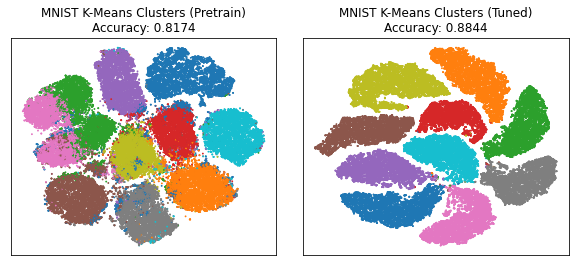

In [ ]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'MNIST K-Means Clusters (Pretrain)\nAccuracy: {pretrain_acc_mnist}')
ax1.scatter(tsne_mnist_pre[:,0], tsne_mnist_pre[:,1], color=get_colors(y_pred_mnist), s=0.7)

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title(f'MNIST K-Means Clusters (Tuned)\nAccuracy: {tuned_acc_mnist}')
ax2.scatter(tsne_mnist_tuned[:,0], tsne_mnist_tuned[:,1], color=get_colors(y_pred_mnist_tuned), s=0.7)

plt.subplots_adjust(wspace=0.1);

## Cluster Labeled Dataset

As proof of concept, the labeled dataset is clustered using DEC in this section.  Because the labeled dataset is much smaller than MNIST, a simpler autoencoder is required.  [Yang et al.](https://arxiv.org/abs/1610.04794) used a similar autoencoder-based clustering architecture on the 20Newsgroup dataset (N=18,846) so their autoencoder layer dimensions of [250, 100, 10] are used to cluster both the labeled and PhaseNet waveform datasets.  For both waveform datasets, two primary clusters are expected: induced earthquakes from fracking activity, and mining blasts.

The results indicate that the labeled dataset is too small and/or simple to take advantage of the full DEC architecture end-to-end.  Following autoencoder pretraining, 99.95% accuracy is already achieved.  The DEC tuning phase has almost no room for improvement, and often causes accuracy to drop instead.  

In [ ]:
N_CLUSTERS = 2

autoencoder_labeled, encoder_labeled = get_autoencoder(dims=[X_labeled.shape[-1], 250, 100, 10])

labeled_pretrain_acc = []

# For labeled data, results got worse after 150 epochs.  Overfitting?
pretrain(autoencoder_labeled, X_labeled, y=y_labeled, epochs=150, acc_list=labeled_pretrain_acc)

...Pretraining...
Epoch 1/150
26/26 [==============================] - 1s 6ms/step - loss: 8.5029e-04
Clustering accuracy: 0.9989
Epoch 2/150
26/26 [==============================] - 0s 5ms/step - loss: 4.5934e-04
Epoch 3/150
26/26 [==============================] - 0s 6ms/step - loss: 3.9675e-04
Epoch 4/150
26/26 [==============================] - 0s 5ms/step - loss: 3.2727e-04
Epoch 5/150
26/26 [==============================] - 0s 5ms/step - loss: 2.9850e-04
Epoch 6/150
26/26 [==============================] - 0s 6ms/step - loss: 2.7979e-04
Epoch 7/150
26/26 [==============================] - 0s 5ms/step - loss: 2.6182e-04
Epoch 8/150
26/26 [==============================] - 0s 5ms/step - loss: 2.5394e-04
Epoch 9/150
26/26 [==============================] - 0s 5ms/step - loss: 2.4116e-04
Epoch 10/150
26/26 [==============================] - 0s 5ms/step - loss: 2.3049e-04
Epoch 11/150
26/26 [==============================] - 0s 5ms/step - loss: 2.2311e-04
Epoch 12/150
26/26 [========

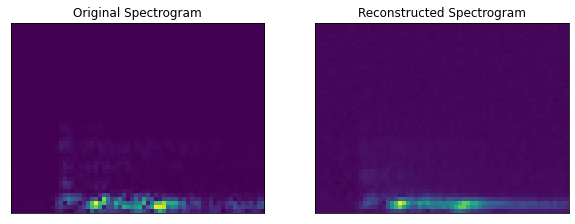

In [ ]:
orig = X_labeled[450]
reconstructed = autoencoder_labeled.predict(np.asarray([orig]))

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.imshow(orig.reshape(48,64), origin='lower');
plt.title('Original Spectrogram')

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.imshow(reconstructed.squeeze().reshape(48,64), origin='lower')
plt.title('Reconstructed Spectrogram');

In [ ]:
tsne_labeled = get_tsne_embedding(X_labeled, encoder_labeled)

In [ ]:
kmeans_labeled = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
y_pred_labeled = kmeans_labeled.fit_predict(encoder_labeled.predict(X_labeled))

num_errors = len(y_labeled) - accuracy_score(y_labeled, y_pred_labeled, normalize=False)
if num_errors > 1000:
  num_errors = len(y_labeled) - num_errors

print(f'Number of clustering errors: {num_errors}')

Number of clustering errors: 3


In [ ]:
clustering_layer_labeled = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder_labeled.output)
model_labeled = Model(inputs=encoder_labeled.input, outputs=clustering_layer_labeled)

labeled_tuned_acc = []

model_labeled.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred_labeled_tuned = fit(X_labeled, y=y_labeled, model=model_labeled, encoder=encoder_labeled, acc_list=labeled_tuned_acc)

print('\n')
num_errors_tuned = len(y_labeled) - accuracy_score(y_labeled, y_pred_labeled_tuned, normalize=False)
if num_errors_tuned > 1000:
  num_errors_tuned = len(y_labeled) - num_errors_tuned
print(f'Number of clustering errors: {num_errors_tuned}')

Update interval 140
Initializing cluster centers with k-means.
Iteration: 0.  Clustering Accuracy: 0.99953.  Loss: 0.
Iteration: 140.  Clustering Accuracy: 0.99953.  Loss: 0.01162.
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


Number of clustering errors: 3


In [ ]:
tsne_labeled_tuned = get_tsne_embedding(X_labeled, encoder_labeled)

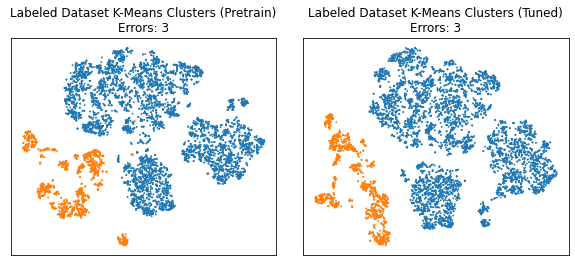

In [ ]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'Labeled Dataset K-Means Clusters (Pretrain)\nErrors: {num_errors}')
ax1.scatter(tsne_labeled[:,0], tsne_labeled[:,1], color=get_colors(y_pred_labeled), s=0.7)

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title(f'Labeled Dataset K-Means Clusters (Tuned)\nErrors: {num_errors_tuned}')
ax2.scatter(tsne_labeled_tuned[:,0], tsne_labeled_tuned[:,1], color=get_colors(y_pred_labeled_tuned), s=0.7)

plt.subplots_adjust(wspace=0.1);

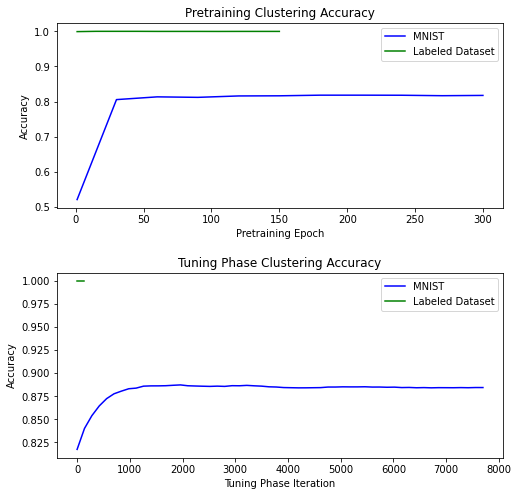

In [ ]:
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(211)
ax1.plot(*zip(*mnist_pretrain_acc), color='b', label='MNIST')
ax1.plot(*zip(*labeled_pretrain_acc), color='g', label='Labeled Dataset')
plt.title('Pretraining Clustering Accuracy')
plt.xlabel('Pretraining Epoch')
plt.ylabel('Accuracy')

plt.legend()

ax2 = plt.subplot(212)
ax2.plot(*zip(*mnist_tuned_acc), color='b', label='MNIST')
ax2.plot(*zip(*labeled_tuned_acc), color='g', label='Labeled Dataset')
plt.title('Tuning Phase Clustering Accuracy')
plt.xlabel('Tuning Phase Iteration')
plt.ylabel('Accuracy')

plt.legend()

plt.subplots_adjust(hspace=0.35);

## Cluster PhaseNet Picks (2 clusters)

The PhaseNet dataset is clustered in the next two sections using the same parameters as the labeled dataset.  Cluster sizes of two and three are examined.  In both cases, clustering results are improved by the tuning phase.  This makes sense, as the PhaseNet dataset is much more "wild" (e.g. more noise signals) than the nicely curated labeled dataset.

In [ ]:
N_CLUSTERS = 2

autoencoder_pn, encoder_pn = get_autoencoder(dims=[X_pn.shape[-1], 250, 100, 10])

# For labeled data, results got worse after 150 epochs.  Overfitting?
pretrain(autoencoder_pn, X_pn, epochs=150)

...Pretraining...
Epoch 1/150
29/29 [==============================] - 1s 6ms/step - loss: 7.8849e-04
Epoch 2/150
29/29 [==============================] - 0s 6ms/step - loss: 4.6330e-04
Epoch 3/150
29/29 [==============================] - 0s 6ms/step - loss: 4.2734e-04
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 3.7294e-04
Epoch 5/150
29/29 [==============================] - 0s 6ms/step - loss: 3.1515e-04
Epoch 6/150
29/29 [==============================] - 0s 6ms/step - loss: 2.8623e-04
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 2.7231e-04
Epoch 8/150
29/29 [==============================] - 0s 5ms/step - loss: 2.5347e-04
Epoch 9/150
29/29 [==============================] - 0s 6ms/step - loss: 2.4057e-04
Epoch 10/150
29/29 [==============================] - 0s 6ms/step - loss: 2.3201e-04
Epoch 11/150
29/29 [==============================] - 0s 5ms/step - loss: 2.2541e-04
Epoch 12/150
29/29 [==============================] - 0s

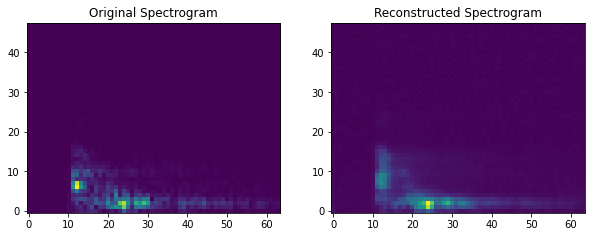

In [ ]:
orig = X_pn[850]
reconstructed = autoencoder_pn.predict(np.asarray([orig]))

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)
ax1.imshow(orig.reshape(48,64), origin='lower');
plt.title('Original Spectrogram')

ax2 = plt.subplot(122)
ax2.imshow(reconstructed.squeeze().reshape(48,64), origin='lower')
plt.title('Reconstructed Spectrogram');

In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/tsne_pn_pre_2C.npy'):
  tsne_pn_pre_2C = get_tsne_embedding(X_pn, encoder_pn)

  kmeans_pn = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
  y_pred_pn_pre_2C = kmeans_pn.fit_predict(encoder_pn.predict(X_pn))
else:
  tsne_pn_pre_2C = np.load(f'{PHASENET_PATH}/tsne_pn_pre_2C.npy')
  y_pred_pn_pre_2C = np.load(f'{PHASENET_PATH}/labels_pn_pre_2C.npy')

unique, counts = np.unique(y_pred_pn_pre_2C, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5733, 1: 1665}


In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/tsne_pn_tuned_2C.npy'):
  clustering_layer_pn = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder_pn.output)
  model_pn = Model(inputs=encoder_pn.input, outputs=clustering_layer_pn)

  model_pn.compile(optimizer=SGD(0.01, 0.9), loss='kld')
  y_pred_pn_tuned_2C = fit(X_pn, model=model_pn, encoder=encoder_pn)

  tsne_pn_tuned_2C = get_tsne_embedding(X_pn, encoder_pn)

  timestamps_pn_tuned_2C = phasenet_timestamps
else:
  tsne_pn_tuned_2C = np.load(f'{PHASENET_PATH}/tsne_pn_tuned_2C.npy')
  y_pred_pn_tuned_2C = np.load(f'{PHASENET_PATH}/labels_pn_tuned_2C.npy')
  timestamps_pn_tuned_2C = np.load(f'{PHASENET_PATH}/timestamps_pn_tuned_2C.npy')


unique, counts = np.unique(y_pred_pn_tuned_2C, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2421, 1: 4977}


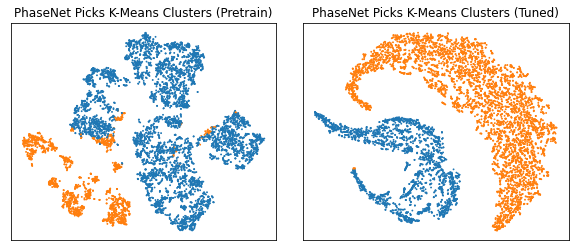

In [ ]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'PhaseNet Picks K-Means Clusters (Pretrain)')
ax1.scatter(tsne_pn_pre_2C[:,0], tsne_pn_pre_2C[:,1], color=get_colors(y_pred_pn_pre_2C), s=0.7)

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title(f'PhaseNet Picks K-Means Clusters (Tuned)')
ax2.scatter(tsne_pn_tuned_2C[:,0], tsne_pn_tuned_2C[:,1], color=get_colors(y_pred_pn_tuned_2C), s=0.7)

plt.subplots_adjust(wspace=0.1);

## Cluster PhaseNet Picks (3 clusters)

In [ ]:
N_CLUSTERS = 3

autoencoder_pn, encoder_pn = get_autoencoder(dims=[X_pn.shape[-1], 250, 100, 10])

# For labeled data, results got worse after 150 epochs.  Overfitting?
pretrain(autoencoder_pn, X_pn, epochs=150)

...Pretraining...
Epoch 1/150
29/29 [==============================] - 1s 6ms/step - loss: 8.0780e-04
Epoch 2/150
29/29 [==============================] - 0s 6ms/step - loss: 4.6867e-04
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 4.2388e-04
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 3.6214e-04
Epoch 5/150
29/29 [==============================] - 0s 5ms/step - loss: 3.2685e-04
Epoch 6/150
29/29 [==============================] - 0s 5ms/step - loss: 3.0391e-04
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 2.8011e-04
Epoch 8/150
29/29 [==============================] - 0s 5ms/step - loss: 2.6166e-04
Epoch 9/150
29/29 [==============================] - 0s 5ms/step - loss: 2.5114e-04
Epoch 10/150
29/29 [==============================] - 0s 5ms/step - loss: 2.4001e-04
Epoch 11/150
29/29 [==============================] - 0s 5ms/step - loss: 2.3275e-04
Epoch 12/150
29/29 [==============================] - 0s

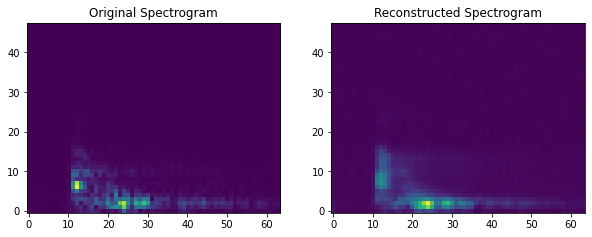

In [ ]:
orig = X_pn[850]
reconstructed = autoencoder_pn.predict(np.asarray([orig]))

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)
ax1.imshow(orig.reshape(48,64), origin='lower');
plt.title('Original Spectrogram')

ax2 = plt.subplot(122)
ax2.imshow(reconstructed.squeeze().reshape(48,64), origin='lower')
plt.title('Reconstructed Spectrogram');

In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/tsne_pn_pre_3C.npy'):
  tsne_pn_pre_3C = get_tsne_embedding(X_pn, encoder_pn)

  kmeans_pn = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
  y_pred_pn_pre_3C = kmeans_pn.fit_predict(encoder_pn.predict(X_pn))
else:
  tsne_pn_pre_3C = np.load(f'{PHASENET_PATH}/tsne_pn_pre_3C.npy')
  y_pred_pn_pre_3C = np.load(f'{PHASENET_PATH}/labels_pn_pre_3C.npy')

unique, counts = np.unique(y_pred_pn_pre_3C, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2053, 1: 2454, 2: 2891}


In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/tsne_pn_tuned_3C.npy'):
  clustering_layer_pn = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder_pn.output)
  model_pn = Model(inputs=encoder_pn.input, outputs=clustering_layer_pn)

  model_pn.compile(optimizer=SGD(0.01, 0.9), loss='kld')
  y_pred_pn_tuned_3C = fit(X_pn, model=model_pn, encoder=encoder_pn)

  tsne_pn_tuned_3C = get_tsne_embedding(X_pn, encoder_pn)

  timestamps_pn_tuned_3C = phasenet_timestamps
else:
  tsne_pn_tuned_3C = np.load(f'{PHASENET_PATH}/tsne_pn_tuned_3C.npy')
  y_pred_pn_tuned_3C = np.load(f'{PHASENET_PATH}/labels_pn_tuned_3C.npy')
  timestamps_pn_tuned_3C = np.load(f'{PHASENET_PATH}/timestamps_pn_tuned_3C.npy')

unique, counts = np.unique(y_pred_pn_tuned_3C, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2942, 1: 2381, 2: 2075}


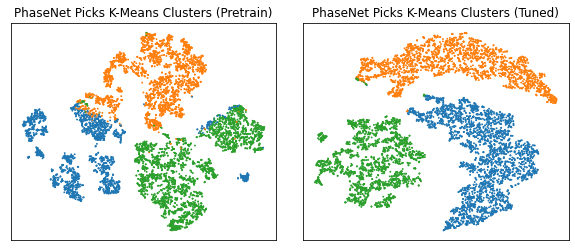

In [ ]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'PhaseNet Picks K-Means Clusters (Pretrain)')
ax1.scatter(tsne_pn_pre_3C[:,0], tsne_pn_pre_3C[:,1], color=get_colors(y_pred_pn_pre_3C), s=0.7)

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title(f'PhaseNet Picks K-Means Clusters (Tuned)')
ax2.scatter(tsne_pn_tuned_3C[:,0], tsne_pn_tuned_3C[:,1], color=get_colors(y_pred_pn_tuned_3C), s=0.7)

plt.subplots_adjust(wspace=0.1);

## Evaluation of Clustering Results

As the PhaseNet dataset is completely unlabeled, clustering results are evaluated using the following three criteria.

1. Histogram of event onset times.  Since mining blasts are a result of human activity, we should expect the blast cluster(s) to mostly contain events with onset times during the day (e.g. working hours).  On the other hand, we should expect earthquake onset times to be more evenly spread throughout the day and night.
2. Histogram of the number of earthquakes per month.  There are four known earthquake clusters in the region during the years spanned by the PhaseNet dataset: Sep-Oct 2013, May 2014, Sep 2015, and Nov 2016.  These clusters should be easily visible in the histogram.
3. Manual inspection of clusters by domain experts using visualization tool.

Visualization tool links
* [Two-cluster solution](https://storage.googleapis.com/d3_phasenet_vis/2clusters.html)
* [Three-cluster solution](https://storage.googleapis.com/d3_phasenet_vis/3clusters.html)

The DEC PhaseNet clustering results pass all three criteria.  See histogram plots for (1) and (2).  For (3), Dr. Yao confirmed that our clustering results are meaningful using the visualization tool.

In [ ]:
data_2C = {
    'cluster': y_pred_pn_tuned_2C, 
    'timestamp': timestamps_pn_tuned_2C
}

df = pd.DataFrame(data_2C, columns=['cluster', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
df['year'] = df.apply(lambda x: x['timestamp'].year, axis=1)

summary_stats_2C = {}

for c in [0,1]:
  df_c = df[df['cluster']==c]
  summary_stats_2C[f'len_{c}'] = len(df_c)
  bars_c = []
  for h in list(range(0,24)):
    df_c_hour = df_c[df_c['hour']==h]
    bars_c.append(len(df_c_hour))
  summary_stats_2C[f'bars_{c}'] = bars_c
  print(f'Cluster length: {len(df_c)}.  Bars length: {np.sum(bars_c)}.')

Cluster length: 2421.  Bars length: 2421.
Cluster length: 4977.  Bars length: 4977.


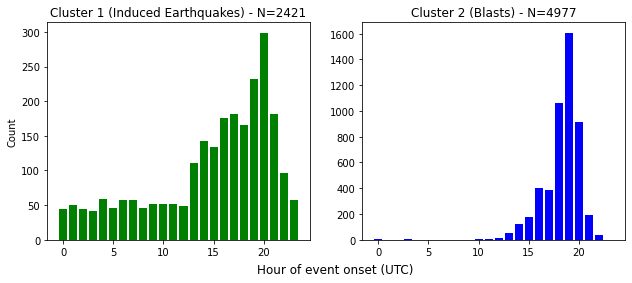

In [ ]:
fig = plt.figure(figsize=(16,4))
fig.text(0.375, 0.01, 'Hour of event onset (UTC)', ha='center', fontsize=12)

xs = list(range(0,24))

ax1 = plt.subplot(131)
ax1.bar(xs, summary_stats_2C['bars_0'], color='g')
plt.title(f"Cluster 1 (Induced Earthquakes) - N={summary_stats_2C['len_0']}")
plt.ylabel('Count')

ax2 = plt.subplot(132)
ax2.bar(xs, summary_stats_2C['bars_1'], color='b')
plt.title(f"Cluster 2 (Blasts) - N={summary_stats_2C['len_1']}");

In [ ]:
years = df['year'].sort_values().unique()

bars = []
num_quakes = []

df_eq_2c = df[df['cluster']==0]
for year in years:
  df_year = df_eq_2c[df_eq_2c['year']==year]
  bar_y = []
  for m in range(1,13):
    df_m = df_year[df_year['month']==m]
    bar_y.append(len(df_m))
  bars.append(bar_y)
  num_quakes.append(len(df_year))
  print(len(df_year), np.sum(bar_y))

780 780
394 394
862 862
385 385


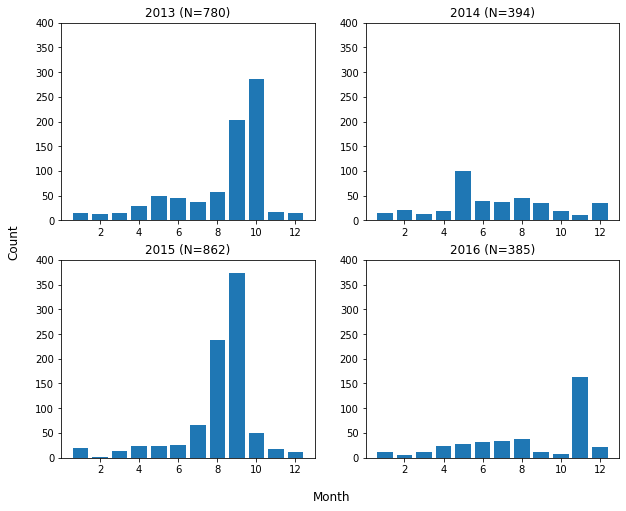

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.text(0.5, 0.05, 'Month', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)

xs = list(range(1,13))
for i in range(len(years)):
  ax = plt.subplot(2,2,i+1)
  ax.bar(xs, bars[i])
  plt.title(f'{years[i]} (N={num_quakes[i]})')
  plt.ylim((0,400))

In [ ]:
data_3C = {
    'cluster': y_pred_pn_tuned_3C, 
    'timestamp': timestamps_pn_tuned_3C
}

df = pd.DataFrame(data_3C, columns=['cluster', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
df['year'] = df.apply(lambda x: x['timestamp'].year, axis=1)

summary_stats_3C = {}

for c in [0,1,2]:
  df_c = df[df['cluster']==c]
  summary_stats_3C[f'len_{c}'] = len(df_c)
  bars_c = []
  for h in list(range(0,24)):
    df_c_hour = df_c[df_c['hour']==h]
    bars_c.append(len(df_c_hour))
  summary_stats_3C[f'bars_{c}'] = bars_c
  print(f'Cluster length: {len(df_c)}.  Bars length: {np.sum(bars_c)}.')


Cluster length: 2942.  Bars length: 2942.
Cluster length: 2381.  Bars length: 2381.
Cluster length: 2075.  Bars length: 2075.


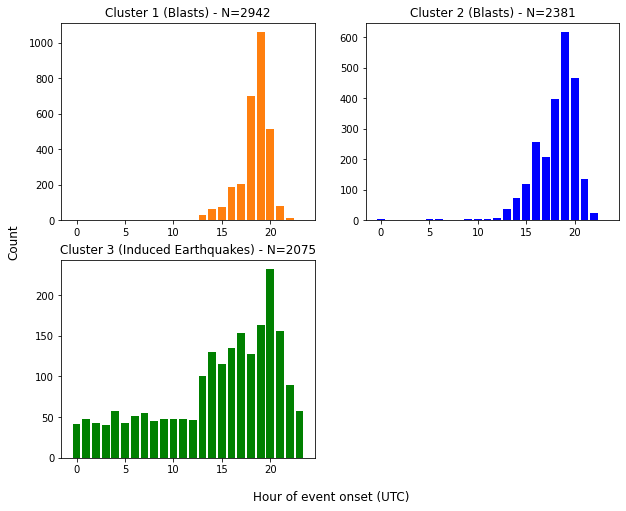

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.text(0.5, 0.05, 'Hour of event onset (UTC)', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)

xs = list(range(0,24))

ax1 = plt.subplot(221)
ax1.bar(xs, summary_stats_3C['bars_0'], color='tab:orange')
plt.title(f"Cluster 1 (Blasts) - N={summary_stats_3C['len_0']}")

ax2 = plt.subplot(222)
ax2.bar(xs, summary_stats_3C['bars_1'], color='b')
plt.title(f"Cluster 2 (Blasts) - N={summary_stats_3C['len_1']}")

ax3 = plt.subplot(223)
ax3.bar(xs, summary_stats_3C['bars_2'], color='g')
plt.title(f"Cluster 3 (Induced Earthquakes) - N={summary_stats_3C['len_2']}");

In [ ]:
years = df['year'].sort_values().unique()

bars = []
num_quakes = []

df_eq_3c = df[df['cluster']==2]
for year in years:
  df_year = df_eq_3c[df_eq_3c['year']==year]
  bar_y = []
  for m in range(1,13):
    df_m = df_year[df_year['month']==m]
    bar_y.append(len(df_m))
  bars.append(bar_y)
  num_quakes.append(len(df_year))
  print(len(df_year), np.sum(bar_y))

650 650
297 297
814 814
314 314


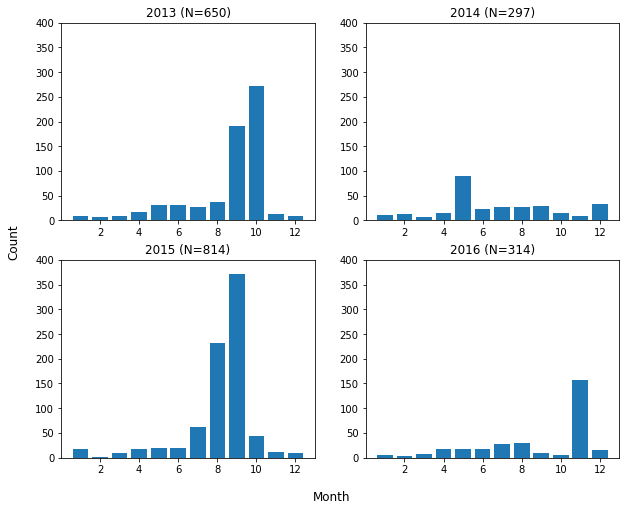

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.text(0.5, 0.05, 'Month', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)

xs = list(range(1,13))
for i in range(len(years)):
  ax = plt.subplot(2,2,i+1)
  ax.bar(xs, bars[i])
  plt.title(f'{years[i]} (N={num_quakes[i]})')
  plt.ylim((0,400))